# EfficientDet for Edge-Aware Image Segmentation
Author: Marcin Mazur

### Setup

In [1]:
import random
import copy
import itertools
import os
import urllib.request
import zipfile
import importlib.util

if importlib.util.find_spec('torchmetrics') is None:
    !pip install torchmetrics
if importlib.util.find_spec('torchinfo') is None:
    !pip install torchinfo

import matplotlib.image as mpimg
import numpy as np
import torch
import torchvision
import torch.nn as nn
import src.helpers as H
from src.utils import Printer, Loss, Plotter, Metric
from src.data import PennFudanDataset, Transformator
from src.nn import EfficientDet
from torchinfo import summary


In [2]:
# Globals
SEED_VAL = 503
BATCH_SIZE = 4
NUM_IMGS_TO_SHOW = 3
IMGS_TO_DROP = [19, 31, 109]
IMG_SIZE = 128
IMG_SIZE_THRESHOLD = 0.01
SEED_VAL = 2147483647
TRAIN_PERCENTAGE = 0.7
VAL_PERCENTAGE = 0.15
DATASET_PATH = os.path.join(os.getcwd(), './data')
NO_CACHE = False
SINGLE_IMAGE_PIXEL_EXTENSION = 12
EDGE_WINDOW_SIZE = 2
DISPLAY = True


In [3]:
seed = np.random.randint(SEED_VAL)
H.seed_all(seed)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using torch: {torch.__version__}')
print(f'Using torchvision: {torchvision.__version__}')
print(f'Using {DEVICE}')
if torch.cuda.is_available():
    !nvidia-smi


Using torch: 1.11.0
Using torchvision: 0.12.0
Using cuda
Fri May 13 11:11:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:26:00.0  On |                  N/A |
| 56%   55C    P0    N/A /  75W |    308MiB /  4038MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                               

In [4]:
if NO_CACHE:
    os.popen('find . | grep -E "(__pycache__|\.pyc|\.pyo$)" | xargs rm -rf')


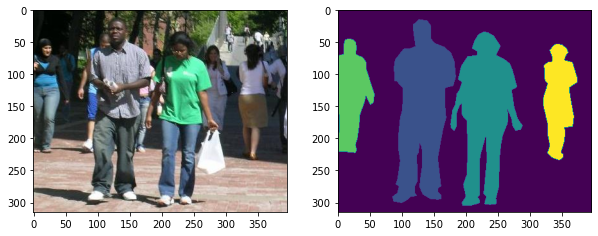

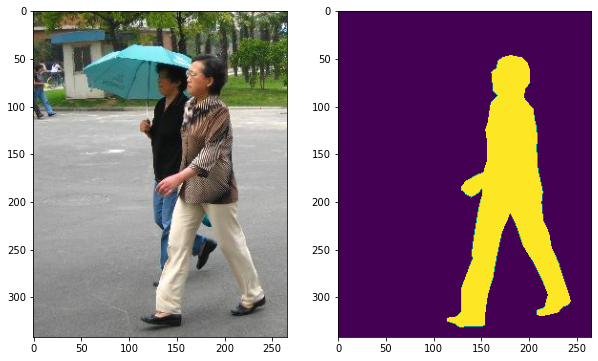

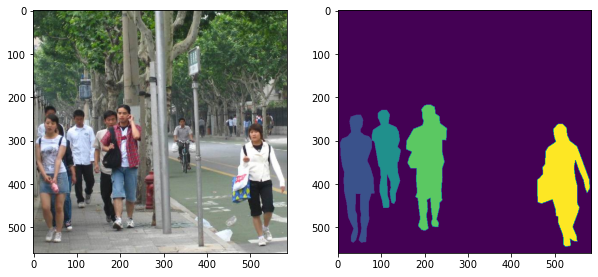

In [5]:
if not os.path.isdir(DATASET_PATH):
    os.mkdir(DATASET_PATH)
    zip_path = os.path.join(DATASET_PATH, 'PennFudanPed.zip')
    urllib.request.urlretrieve('https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip', zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)

imgs_path = os.path.join(DATASET_PATH, 'PennFudanPed', 'PNGImages')
masks_path = os.path.join(DATASET_PATH, 'PennFudanPed', 'PedMasks')

imgs_path = [os.path.join(imgs_path, img) for img in sorted(os.listdir(imgs_path))]
imgs_path = [img for i, img in enumerate(imgs_path) if i not in IMGS_TO_DROP]
masks_path = [os.path.join(masks_path, mask) for mask in sorted(os.listdir(masks_path))]
masks_path = [mask for i, mask in enumerate(masks_path) if i not in IMGS_TO_DROP]
imgs_path, masks_path = zip(*random.sample(list(zip(imgs_path, masks_path)), len(imgs_path)))

if DISPLAY:
    for i in range(NUM_IMGS_TO_SHOW):
        Printer.imshow(mpimg.imread(imgs_path[i]), mpimg.imread(masks_path[i]))

train_split_index = int(len(imgs_path) * TRAIN_PERCENTAGE)
val_split_index = int(len(imgs_path) * (TRAIN_PERCENTAGE + VAL_PERCENTAGE))

train_imgs_path = imgs_path[:train_split_index]
train_masks_path = masks_path[:train_split_index]

val_imgs_path = imgs_path[train_split_index:val_split_index]
val_masks_path = masks_path[train_split_index:val_split_index:]

test_imgs_path = imgs_path[val_split_index:]
test_masks_path = masks_path[val_split_index:]


### Data Preparation

Number of images in training: 116, validation: 25 test: 26


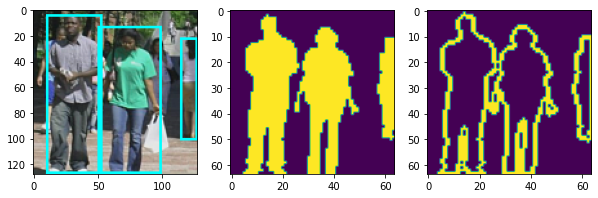

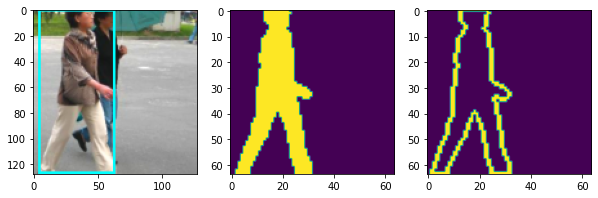

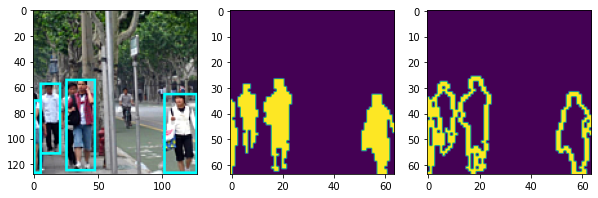

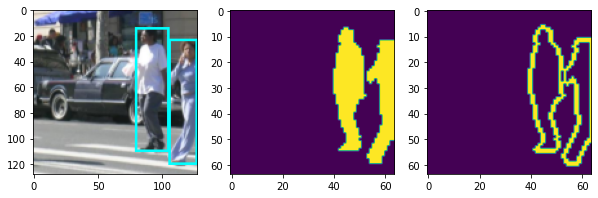

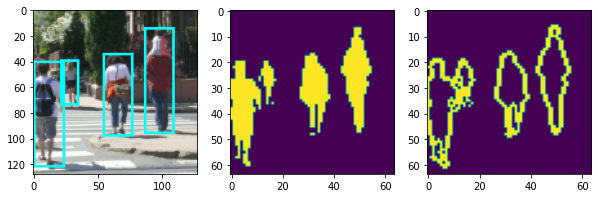

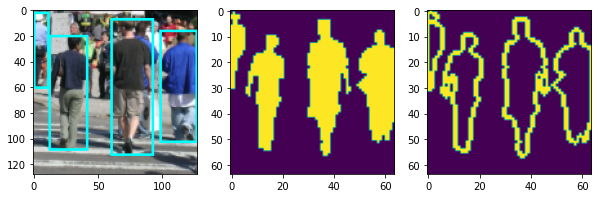

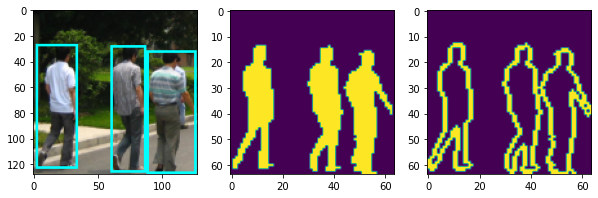

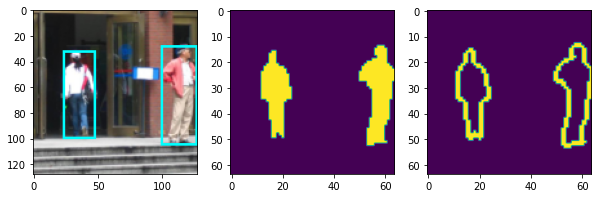

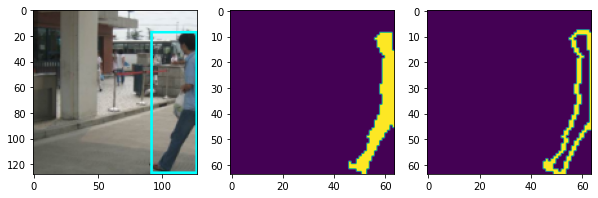

In [6]:
print(
    f'Number of images in training: {train_split_index}, validation: {val_split_index - train_split_index} test: {len(imgs_path) - val_split_index}')
dataset_tr = PennFudanDataset(train_imgs_path, train_masks_path, IMG_SIZE_THRESHOLD, transforms=Transformator.get_transform(IMG_SIZE, True))
dataset_val = PennFudanDataset(val_imgs_path, val_masks_path, IMG_SIZE_THRESHOLD, transforms=Transformator.get_transform(IMG_SIZE, False))
dataset_test = PennFudanDataset(test_imgs_path, test_masks_path, IMG_SIZE_THRESHOLD,
                                transforms=Transformator.get_transform(IMG_SIZE, False))

if DISPLAY:
    # Find images without boxes
    for _ in range(0):
        seed = np.random.randint(SEED_VAL)
        H.seed_all(seed)
        dataset = PennFudanDataset(imgs_path, masks_path, IMG_SIZE_THRESHOLD, transforms=Transformator.get_transform(IMG_SIZE, True))
        no_obj = []
        for i, data in enumerate(dataset):
            if len(PennFudanDataset.get_boxes(data[2])) == 0:
                no_obj.append(i)
        print(f'Images without objectives: {no_obj}')
    # Display transformed images
    for img, mask, edge_mask, boxes in itertools.islice(dataset_tr, NUM_IMGS_TO_SHOW):
        Printer.imshow_with_masks_and_boxes(IMG_SIZE, img, mask, edge_mask, boxes)
    for img, mask, edge_mask, boxes in itertools.islice(dataset_val, NUM_IMGS_TO_SHOW):
        Printer.imshow_with_masks_and_boxes(IMG_SIZE, img, mask, edge_mask, boxes)
    for img, mask, edge_mask, boxes in itertools.islice(dataset_test, NUM_IMGS_TO_SHOW):
        Printer.imshow_with_masks_and_boxes(IMG_SIZE, img, mask, edge_mask, boxes)


In [7]:
loader_tr = torch.utils.data.DataLoader(dataset_tr, BATCH_SIZE, shuffle=True, num_workers=4)
loader_val = torch.utils.data.DataLoader(dataset_val, BATCH_SIZE, shuffle=True, num_workers=2)
loader_test = torch.utils.data.DataLoader(dataset_test, BATCH_SIZE, num_workers=2)


### Model

In [8]:
blocks = [2, 3, 4, 6, 7]

in_ch = [16, 24, 40, 112, 192]  # Efficient defined
bifpn1_args = [in_ch, 256, 128]

in_ch = [bifpn1_args[-1]] * 5
bifpn2_args = [in_ch, 512, 256]

in_ch = [bifpn2_args[-1]] * 5
bifpn3_args = [in_ch, 1024, 512]

sigmas = [nn.SiLU, nn.ReLU, nn.Sigmoid]
ch = [bifpn3_args[-1], 128, 64]
kernels = [3, 1]
kwargs = [{'padding': 1}, {}]
mask_args = [sigmas, ch, kernels, kwargs]
edge_args = [sigmas, ch, kernels, kwargs]

model = EfficientDet(blocks, [bifpn1_args, bifpn2_args, bifpn3_args], mask_args, edge_args).to(DEVICE)
summary(model, (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))


Layer (type:depth-idx)                                       Output Shape              Param #
EfficientDet                                                 --                        --
├─EffNet: 1-1                                                [4, 16, 64, 64]           --
│    └─Sequential: 2-1                                       [4, 16, 64, 64]           --
│    │    └─ConvNormActivation: 3-1                          [4, 32, 64, 64]           928
│    │    └─Sequential: 3-2                                  [4, 16, 64, 64]           1,448
│    └─Sequential: 2-2                                       [4, 24, 32, 32]           --
│    │    └─Sequential: 3-3                                  [4, 24, 32, 32]           16,714
│    └─Sequential: 2-3                                       [4, 40, 16, 16]           --
│    │    └─Sequential: 3-4                                  [4, 40, 16, 16]           46,640
│    └─Sequential: 2-4                                       [4, 112, 8, 8]        

### Training

In [9]:
def show_random_preds(images, masks_pred, edges_pred, boxes, iou_threshold, num_imgs_to_show=1):
    to_print = list(itertools.chain.from_iterable((images[i], H.discretize(masks_pred[i], iou_threshold), H.discretize(
        edges_pred[i], iou_threshold), PennFudanDataset.get_boxes(boxes[i])) for i in range(images.shape[0])))
    Printer.imshow_with_masks_and_boxes_random(IMG_SIZE, *to_print, num_imgs_to_show=num_imgs_to_show)


def gen_scheds(optim):
    sched_warmup = torch.optim.lr_scheduler.LinearLR(optim, start_factor=0.5, end_factor=1.0, total_iters=10)
    sched_cut = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.1, patience=10, min_lr=1e-6, threshold=1e-8, verbose=True)
    return sched_warmup, sched_cut


29 training batches, validation after 3 batches, raport after 12 batches

[1,    12]
Trainging mask loss / iou: 4.87 / 36, edge loss / iou: 6.15 / 16


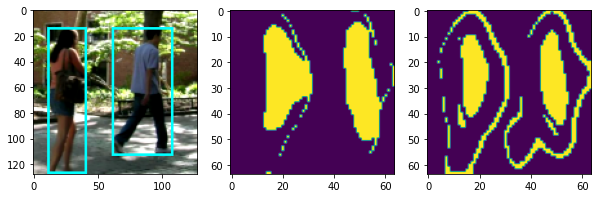

Validation mask loss / iou: 5.65 /  0, edge loss / iou: 5.28 /  4


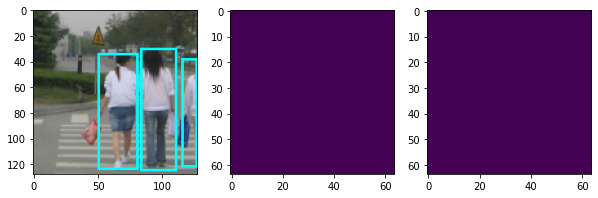

[1,    24]
Trainging mask loss / iou: 4.22 / 42, edge loss / iou: 5.04 / 13


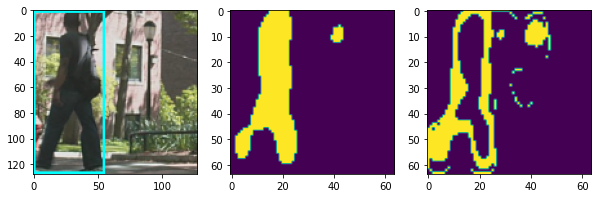

Validation mask loss / iou: 5.45 /  1, edge loss / iou: 4.62 /  2


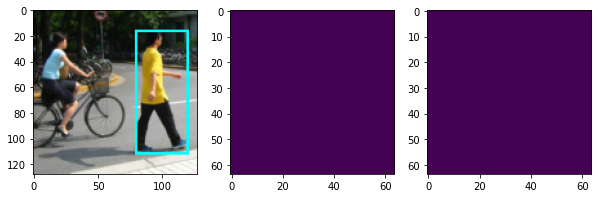

[2,    12]
Trainging mask loss / iou: 2.54 / 59, edge loss / iou: 3.09 / 11


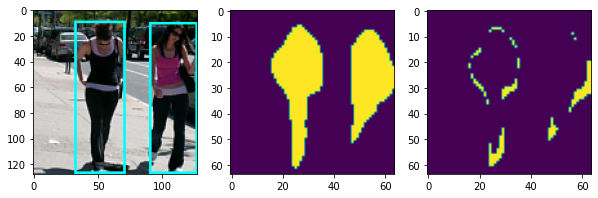

Validation mask loss / iou: 3.23 / 45, edge loss / iou: 3.38 /  5


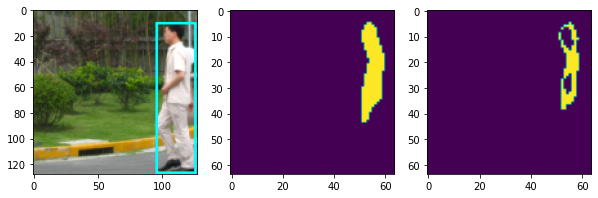

[2,    24]
Trainging mask loss / iou: 2.42 / 60, edge loss / iou: 2.97 / 12


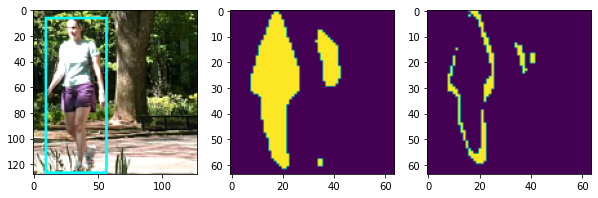

Validation mask loss / iou: 2.91 / 54, edge loss / iou: 3.29 /  6


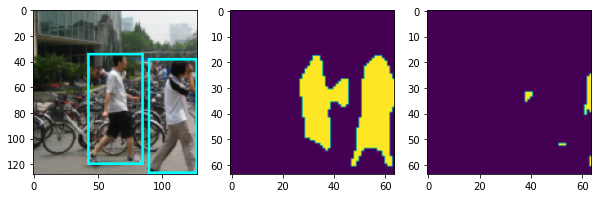

[3,    12]
Trainging mask loss / iou: 2.08 / 69, edge loss / iou: 2.70 / 28


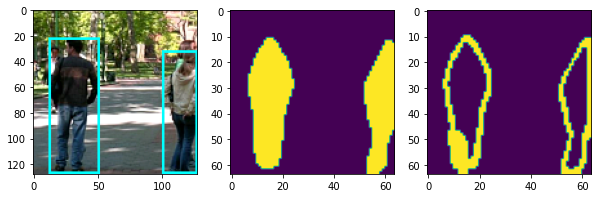

Validation mask loss / iou: 2.34 / 67, edge loss / iou: 2.98 / 24


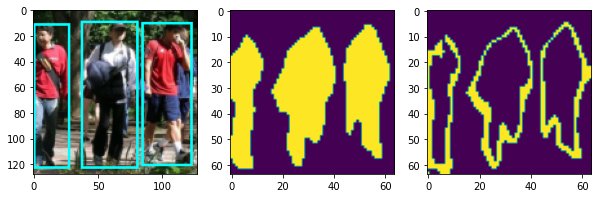

[3,    24]
Trainging mask loss / iou: 2.09 / 66, edge loss / iou: 2.65 / 26


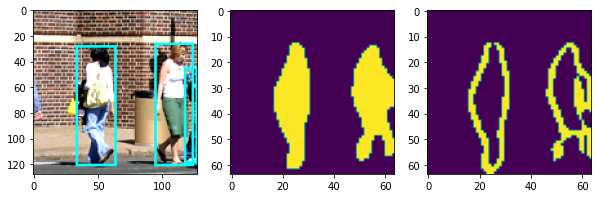

Validation mask loss / iou: 2.73 / 65, edge loss / iou: 3.13 / 22


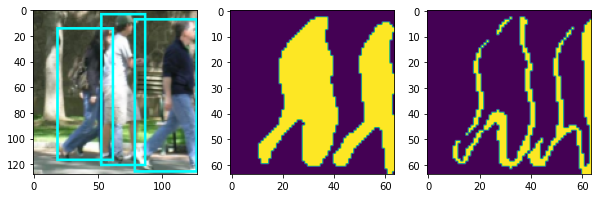

[4,    12]
Trainging mask loss / iou: 2.16 / 64, edge loss / iou: 2.66 / 24


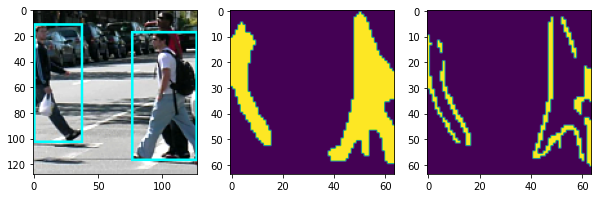

Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00013: reducing learning rate of group 1 to 1.0000e-05.
Validation mask loss / iou: 3.32 / 64, edge loss / iou: 3.27 / 20


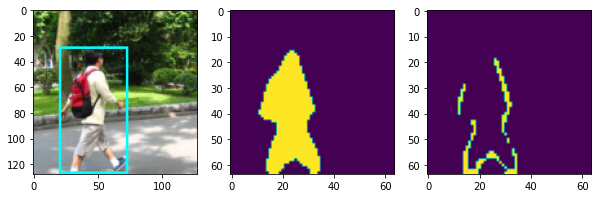

[4,    24]
Trainging mask loss / iou: 1.99 / 67, edge loss / iou: 2.51 / 29


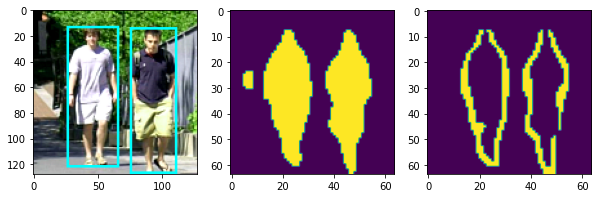

Validation mask loss / iou: 2.91 / 66, edge loss / iou: 3.05 / 26


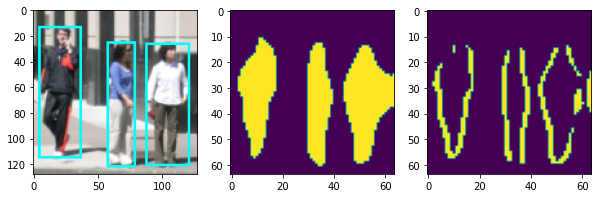

[5,    12]
Trainging mask loss / iou: 1.61 / 73, edge loss / iou: 2.18 / 39


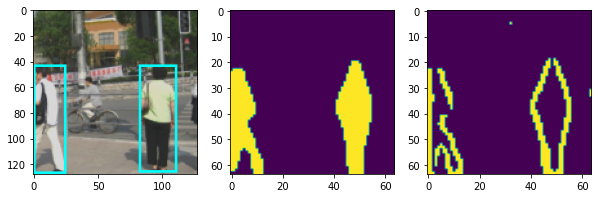

Validation mask loss / iou: 2.14 / 69, edge loss / iou: 2.66 / 37


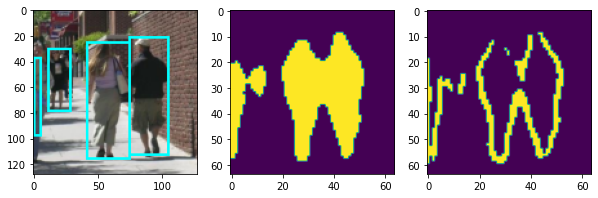

[5,    24]
Trainging mask loss / iou: 1.71 / 72, edge loss / iou: 2.29 / 38


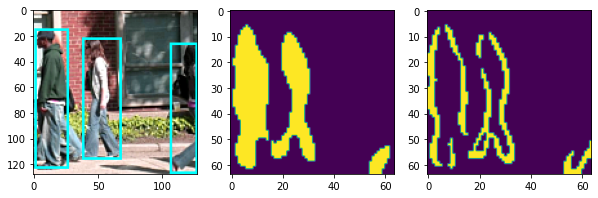

Validation mask loss / iou: 2.14 / 69, edge loss / iou: 2.66 / 36


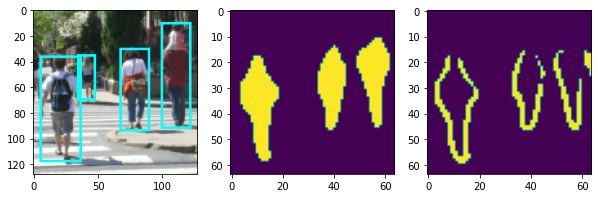

[6,    12]
Trainging mask loss / iou: 1.60 / 74, edge loss / iou: 2.22 / 39


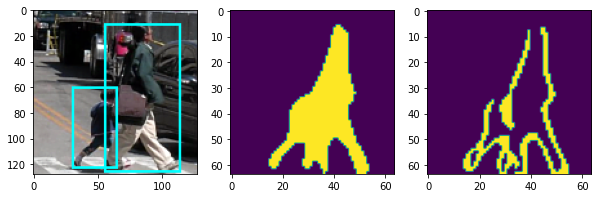

Validation mask loss / iou: 2.01 / 71, edge loss / iou: 2.54 / 38


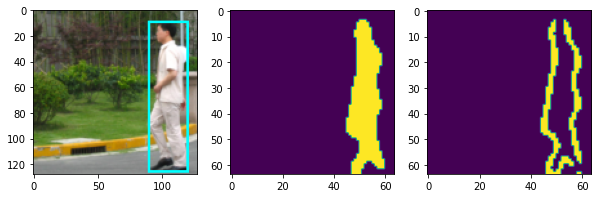

[6,    24]
Trainging mask loss / iou: 1.60 / 73, edge loss / iou: 2.21 / 39


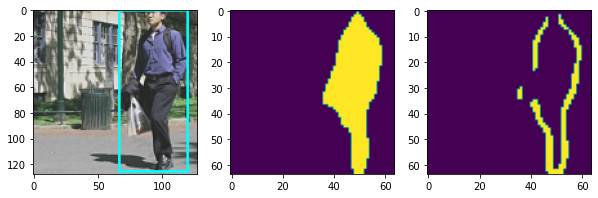

Validation mask loss / iou: 1.99 / 71, edge loss / iou: 2.52 / 38


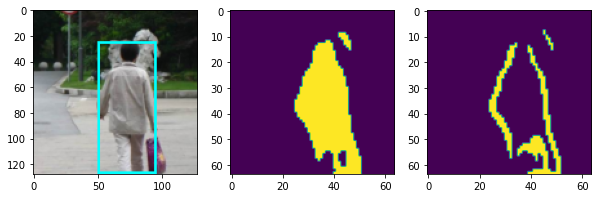

[7,    12]
Trainging mask loss / iou: 1.48 / 74, edge loss / iou: 2.14 / 41


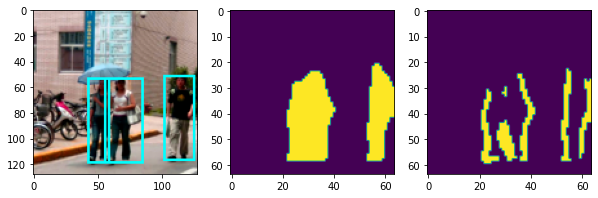

Validation mask loss / iou: 1.96 / 72, edge loss / iou: 2.52 / 40


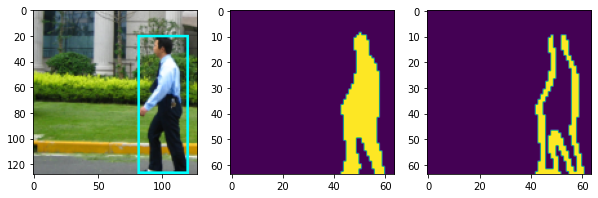

[7,    24]
Trainging mask loss / iou: 1.58 / 74, edge loss / iou: 2.21 / 41


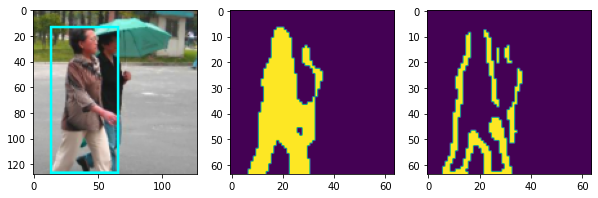

Validation mask loss / iou: 1.98 / 72, edge loss / iou: 2.54 / 40


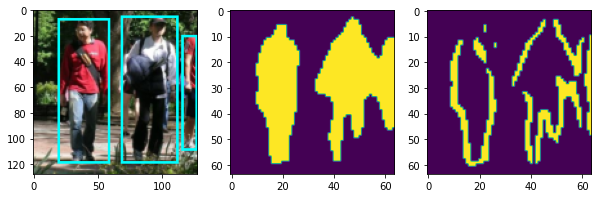

[8,    12]
Trainging mask loss / iou: 1.44 / 75, edge loss / iou: 2.07 / 42


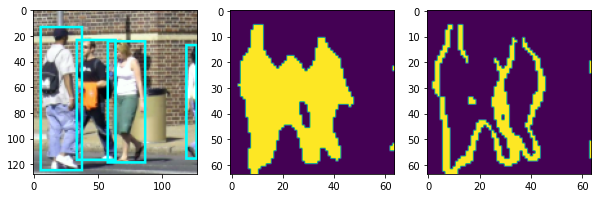

Validation mask loss / iou: 1.95 / 72, edge loss / iou: 2.46 / 41


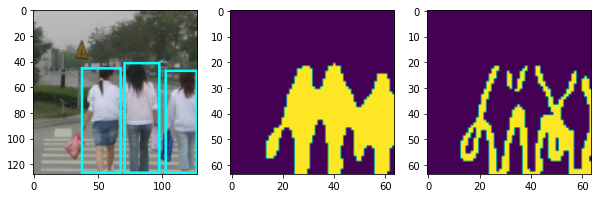

[8,    24]
Trainging mask loss / iou: 1.56 / 74, edge loss / iou: 2.15 / 42


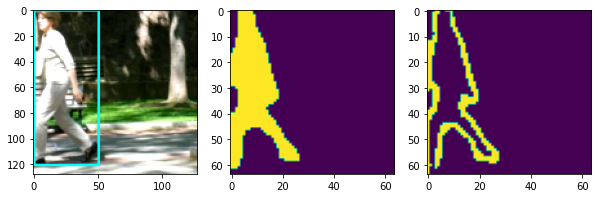

Epoch 00053: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00053: reducing learning rate of group 1 to 1.0000e-06.
Validation mask loss / iou: 1.98 / 71, edge loss / iou: 2.52 / 41


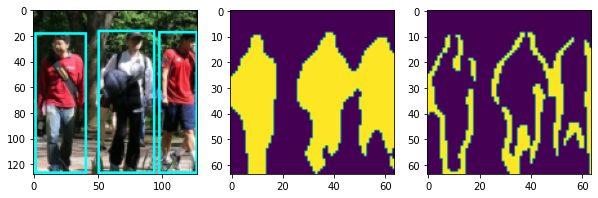

[9,    12]
Trainging mask loss / iou: 1.56 / 74, edge loss / iou: 2.17 / 43


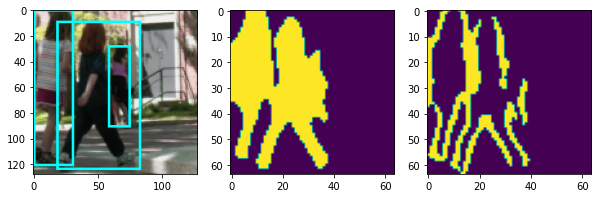

Validation mask loss / iou: 2.01 / 71, edge loss / iou: 2.54 / 39


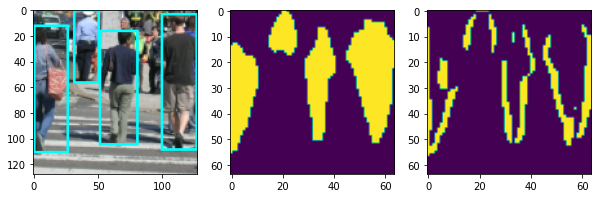

[9,    24]
Trainging mask loss / iou: 1.52 / 74, edge loss / iou: 2.11 / 43


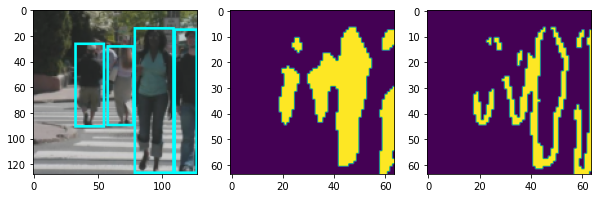

Validation mask loss / iou: 2.02 / 71, edge loss / iou: 2.54 / 40


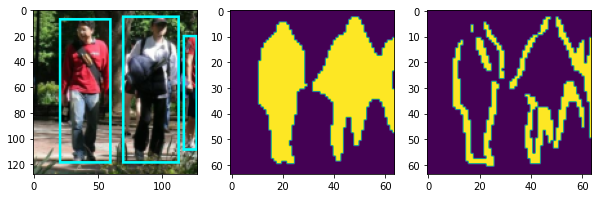

Epoch 00064: reducing learning rate of group 0 to 1.0000e-06.
[10,    12]
Trainging mask loss / iou: 1.64 / 73, edge loss / iou: 2.20 / 43


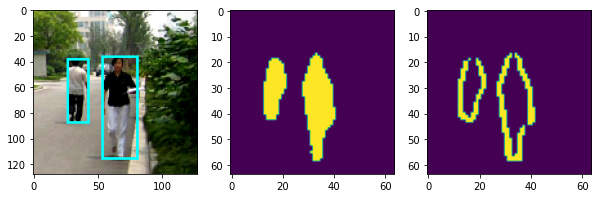

Validation mask loss / iou: 2.12 / 69, edge loss / iou: 2.61 / 38


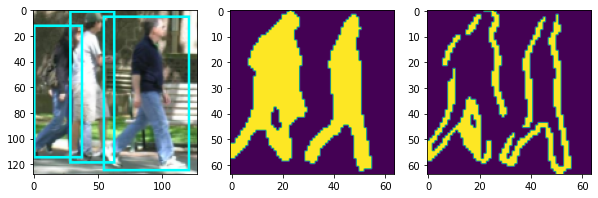

[10,    24]
Trainging mask loss / iou: 1.64 / 73, edge loss / iou: 2.22 / 42


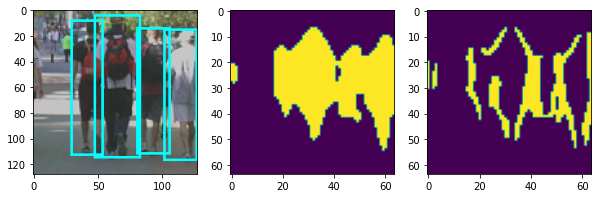

Validation mask loss / iou: 2.00 / 71, edge loss / iou: 2.51 / 40


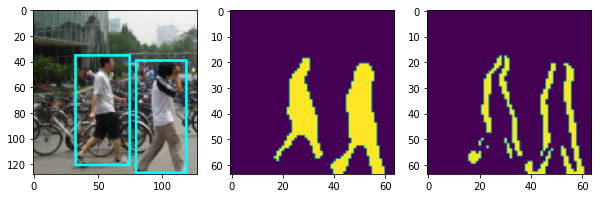

In [10]:
# Hypers
epochs = 10
val_per_epoch = 10
lr = 1e-3
lr_fine = 1e-4

optimizer = torch.optim.RMSprop([{'params': model.get_non_backbone_params()}], lr)
sched_warmup, sched_cut = gen_scheds(optimizer)
fine_tuning = 2

edge_ratio = 0.15
round_ratio = 0.1
iou_threshold = 0.42
L = Loss('bce', gamma=2)

# Training loop
raports_per_epoch = 2
results_tr = {'loss': np.zeros(epochs), 'mask': np.zeros(epochs), 'edge': np.zeros(epochs)}
results_val = {'loss': np.zeros(epochs), 'mask': np.zeros(epochs), 'edge': np.zeros(epochs)}
best_epoch = 0
best_model = None

val_gap = round(len(loader_tr) / val_per_epoch)
raport_gap = val_gap * ((len(loader_tr) // raports_per_epoch) // val_gap)
print(f'{len(loader_tr)} training batches, validation after {val_gap} batches, raport after {raport_gap} batches\n')
for epoch in range(epochs):

    running_tr = {'loss': [], 'mask': [], 'edge': []}
    running_val = {'loss': [], 'mask': [], 'edge': []}
    running_mask_loss, running_edge_loss = [], []
    test_mask_loss, test_edge_loss = [], []
    for i, data in enumerate(loader_tr, 0):
        images, masks, edges, boxes = (data_col.to(DEVICE) for data_col in data)
        model.train()
        optimizer.zero_grad()

        masks_pred, edges_pred = model(images)
        assert masks_pred.shape == masks.shape and edges_pred.shape == edges.shape
        full_loss, mask_loss, edge_loss = L.loss(masks_pred, masks, edges_pred, edges, edge_ratio, iou_threshold, round_ratio)
        mask_iou = Metric.iou(masks_pred, masks, threshold=iou_threshold)
        edge_iou = Metric.iou(edges_pred, edges, threshold=iou_threshold)

        full_loss.backward()
        optimizer.step()
        sched_warmup.step()

        # Statisitcs
        with torch.no_grad():
            running_tr['loss'].append(full_loss.mean().item())
            running_tr['mask'].append(mask_iou.mean().item())
            running_tr['edge'].append(edge_iou.mean().item())
            running_mask_loss.append(mask_loss.mean().item())
            running_edge_loss.append(edge_loss.mean().item())

            # Evaluation
            if (i + 1) % val_gap == 0:
                val_ep = epoch // val_gap
                model.eval()
                if (i + 1) % raport_gap == 0:
                    print(f'[{epoch + 1}, {i + 1:5d}]')
                    print(f'Trainging mask loss / iou: {10 * np.mean(running_mask_loss):.2f} / {100 * np.mean(running_tr["mask"]):2.0f}, '
                          f'edge loss / iou: {10 * np.mean(running_edge_loss):.2f} / {100 * np.mean(running_tr["edge"]):2.0f}')
                    show_random_preds(images, masks_pred, edges_pred, boxes, iou_threshold)

                num_val = len(running_val['loss'])
                for data in loader_val:
                    images, masks, edges, boxes = (data_col.to(DEVICE) for data_col in data)
                    masks_pred, edges_pred = model(images)
                    full_loss, mask_loss, edge_loss = L.loss(masks_pred, masks, edges_pred, edges, edge_ratio, iou_threshold, round_ratio)
                    mask_iou = Metric.iou(masks_pred, masks, threshold=iou_threshold)
                    edge_iou = Metric.iou(edges_pred, edges, threshold=iou_threshold)

                    running_val['loss'].append(full_loss.mean().item())
                    running_val['mask'].append(mask_iou.mean().item())
                    running_val['edge'].append(edge_iou.mean().item())
                    test_mask_loss.append(mask_loss.mean().item())
                    test_edge_loss.append(edge_loss.mean().item())
                sched_cut.step(np.mean(running_val['loss'][num_val:]))

                if (i + 1) % raport_gap == 0:
                    print(f'Validation mask loss / iou: {10 * np.mean(test_mask_loss):.2f} / {100 * np.mean(running_val["mask"]):2.0f}, '
                          f'edge loss / iou: {10 * np.mean(test_edge_loss):.2f} / {100 * np.mean(running_val["edge"]):2.0f}')
                    show_random_preds(images, masks_pred, edges_pred, boxes, iou_threshold)

    for key in results_tr.keys():
        results_tr[key][epoch] = np.mean(running_tr[key])
        results_val[key][epoch] = np.mean(running_val[key])
    if epoch == 0 or np.max(results_val['mask'][:epoch]) < results_val['mask'][epoch]:
        best_epoch = epoch
        best_model = copy.deepcopy(model.state_dict())
    if epoch + 1 == fine_tuning:
        optimizer.add_param_group({'params': model.get_backbone_params(), 'lr': lr_fine})
        sched_warmup, sched_cut = gen_scheds(optimizer)


### Raport

In [11]:
model.load_state_dict(best_model)
model.eval()
print(f'Model evaluated on epoch: {best_epoch + 1}')

with torch.no_grad():
    test_loss, test_mask_iou, test_edge_iou = [], [], []
    for data in loader_test:
        images, masks, edges, boxes = (data_col.to(DEVICE) for data_col in data)
        masks_pred, edges_pred = model(images)
        full_loss, _, _ = L.loss(masks_pred, masks, edges_pred, edges, edge_ratio, iou_threshold, round_ratio)
        test_loss.append(full_loss.mean().item())
        test_mask_iou.append(Metric.iou(masks_pred, masks, threshold=iou_threshold).mean().item())
        test_edge_iou.append(Metric.iou(edges_pred, edges, threshold=iou_threshold).mean().item())
    print(f'Test loss: {10 * np.mean(test_loss):.3f}, ',
          f'iou mask: {100 * np.mean(test_mask_iou):2.0f}, '
          f'iou edge: {100 * np.mean(test_edge_iou):2.0f}')

model_name = H.save_model(best_model, optimizer, L.mode, (best_epoch + 1), lr, np.mean(test_mask_iou))


Model evaluated on epoch: 8
Test loss: 9.910,  iou mask: 72, iou edge: 40


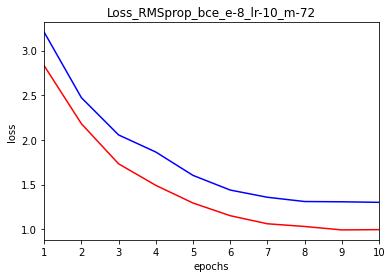

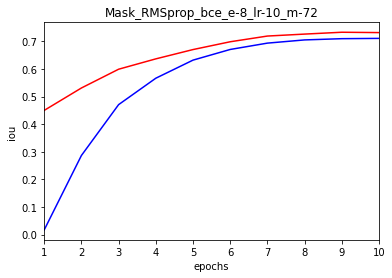

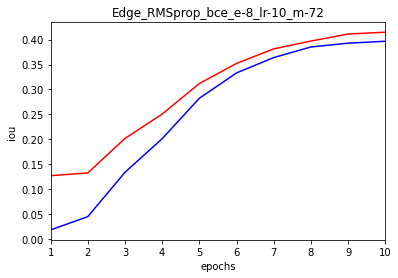

In [12]:
scale_diff = 0
plotter = Plotter(scale_diff)
x = list(range(scale_diff + 1, epochs + 1))
plotter.plot('Loss_' + model_name, 'epochs', 'loss', x, results_tr['loss'], results_val['loss'], 0.5)
plotter.plot('Mask_' + model_name, 'epochs', 'iou', x, results_tr['mask'], results_val['mask'], 0.5)
plotter.plot('Edge_' + model_name, 'epochs', 'iou', x, results_tr['edge'], results_val['edge'], 0.5)


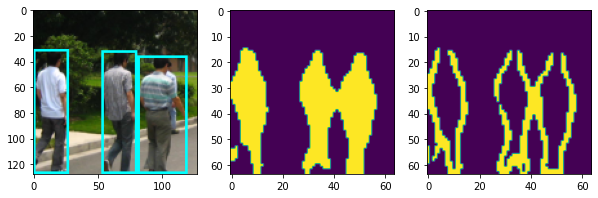

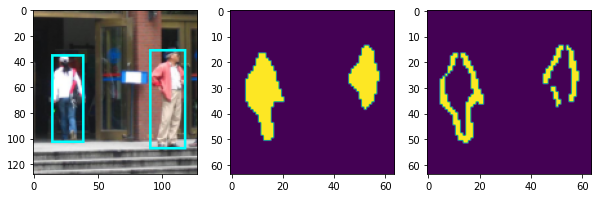

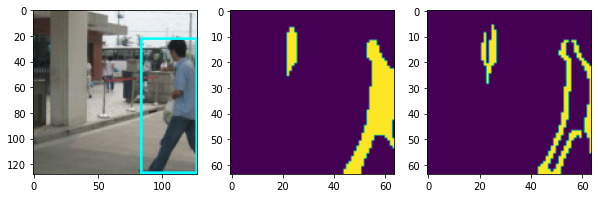

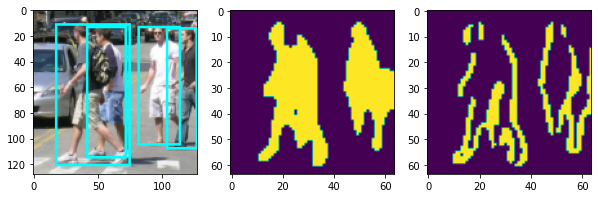

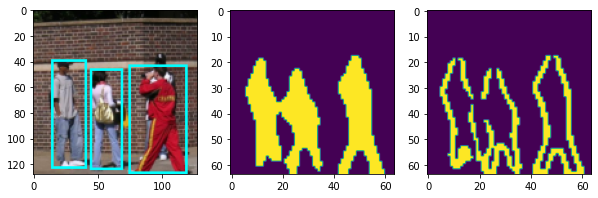

In [13]:
# path = ...
path = './models/' + model_name + '.ckpt'
model.load_state_dict(torch.load(path))
model.eval()

num_to_compare = 5
with torch.no_grad():
    for data in loader_test:
        images, masks, edges, boxes = (data_col.to(DEVICE) for data_col in data)
        masks_pred, edges_pred = model(images)
        show_random_preds(images, masks_pred, edges_pred, boxes, iou_threshold, num_imgs_to_show=num_to_compare)
        num_to_compare -= images.shape[0]
        if num_to_compare <= 0:
            break
